# Notebook simple para comprobar el funcionamiento de GitHub

Este notebook es una excusa para probar el funcionamiento de los comando de GitHub.

## 📦 Importación de librerías

En esta sección se importan las bibliotecas necesarias para el análisis de datos, la construcción del modelo y el seguimiento de experimentos. Se incluyen herramientas para procesamiento de datos (`pandas`, `numpy`), visualización (`matplotlib`), preprocesamiento y partición del dataset (`sklearn`), modelado con redes neuronales convolucionales 1D (`keras`), y gestión de experimentos con MLflow.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


import mlflow
import mlflow.keras

## 📄 Carga + Informe simple

Se carga el dataset procesado desde un archivo CSV que contiene registros de pozo.


In [40]:
# Ruta y carga
ruta = r"C:\Users\andre\Proyectos\facies_well\FC_AC_collab\Data\Processed_Wells.csv"
df = pd.read_csv(ruta)

# Eliminar columnas no deseadas
df = df.drop(columns=['Formation', 'Well Name', 'Depth', 'RELPOS'], errors='ignore')

# Usar directamente 'Facies' como target numérico
print("Valores únicos de facies:", df['Facies'].unique())


Valores únicos de facies: [3 2 8 6 7 4 5 9 1]


Número de muestras por cada clase de Facies:
 Facies
1    268
2    940
3    780
4    271
5    296
6    582
7    141
8    686
9    105
Name: count, dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_33276\3863953417.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=facies_counts.index, y=facies_counts.values, palette="viridis")


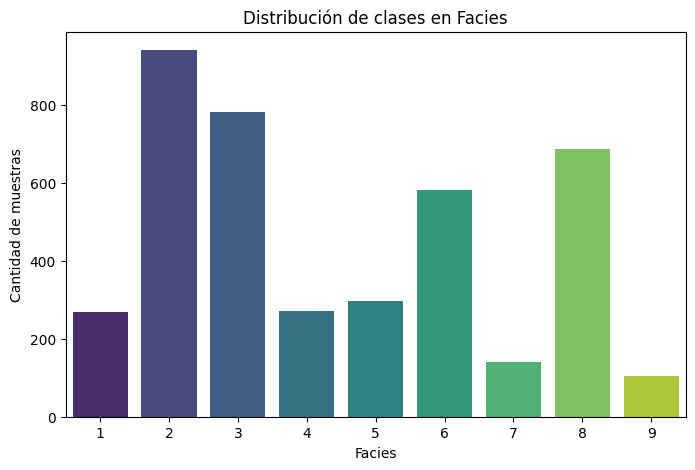

In [41]:
# Distribución de clases en la columna 'Facies'
import matplotlib.pyplot as plt
import seaborn as sns

# Contar filas por cada valor de 'Facies'
facies_counts = df['Facies'].value_counts().sort_index()
print("Número de muestras por cada clase de Facies:\n", facies_counts)

# Graficar distribución
plt.figure(figsize=(8,5))
sns.barplot(x=facies_counts.index, y=facies_counts.values, palette="viridis")
plt.xlabel('Facies')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases en Facies')
plt.show()


📊 Informe de outliers:

🔎 Filas con al menos un outlier: 313 de 2848 totales (10.99%)


,outliers
PHIND,115
DeltaPHI,110
GR,61
ILD_log10,53
PE,43
NM_M,0



✅ Dataset limpio: 2535 filas restantes de 2848 originales


C:\Users\andre\AppData\Local\Temp\ipykernel_33276\432546114.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Antes', 'Después'])
C:\Users\andre\AppData\Local\Temp\ipykernel_33276\432546114.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Antes', 'Después'])
C:\Users\andre\AppData\Local\Temp\ipykernel_33276\432546114.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Antes', 'Después'])
C:\Users\andre\AppData\Local\Temp\ipykernel_33276\432546114.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Antes', 'Después'])
C:\Users\andre\AppData\Local

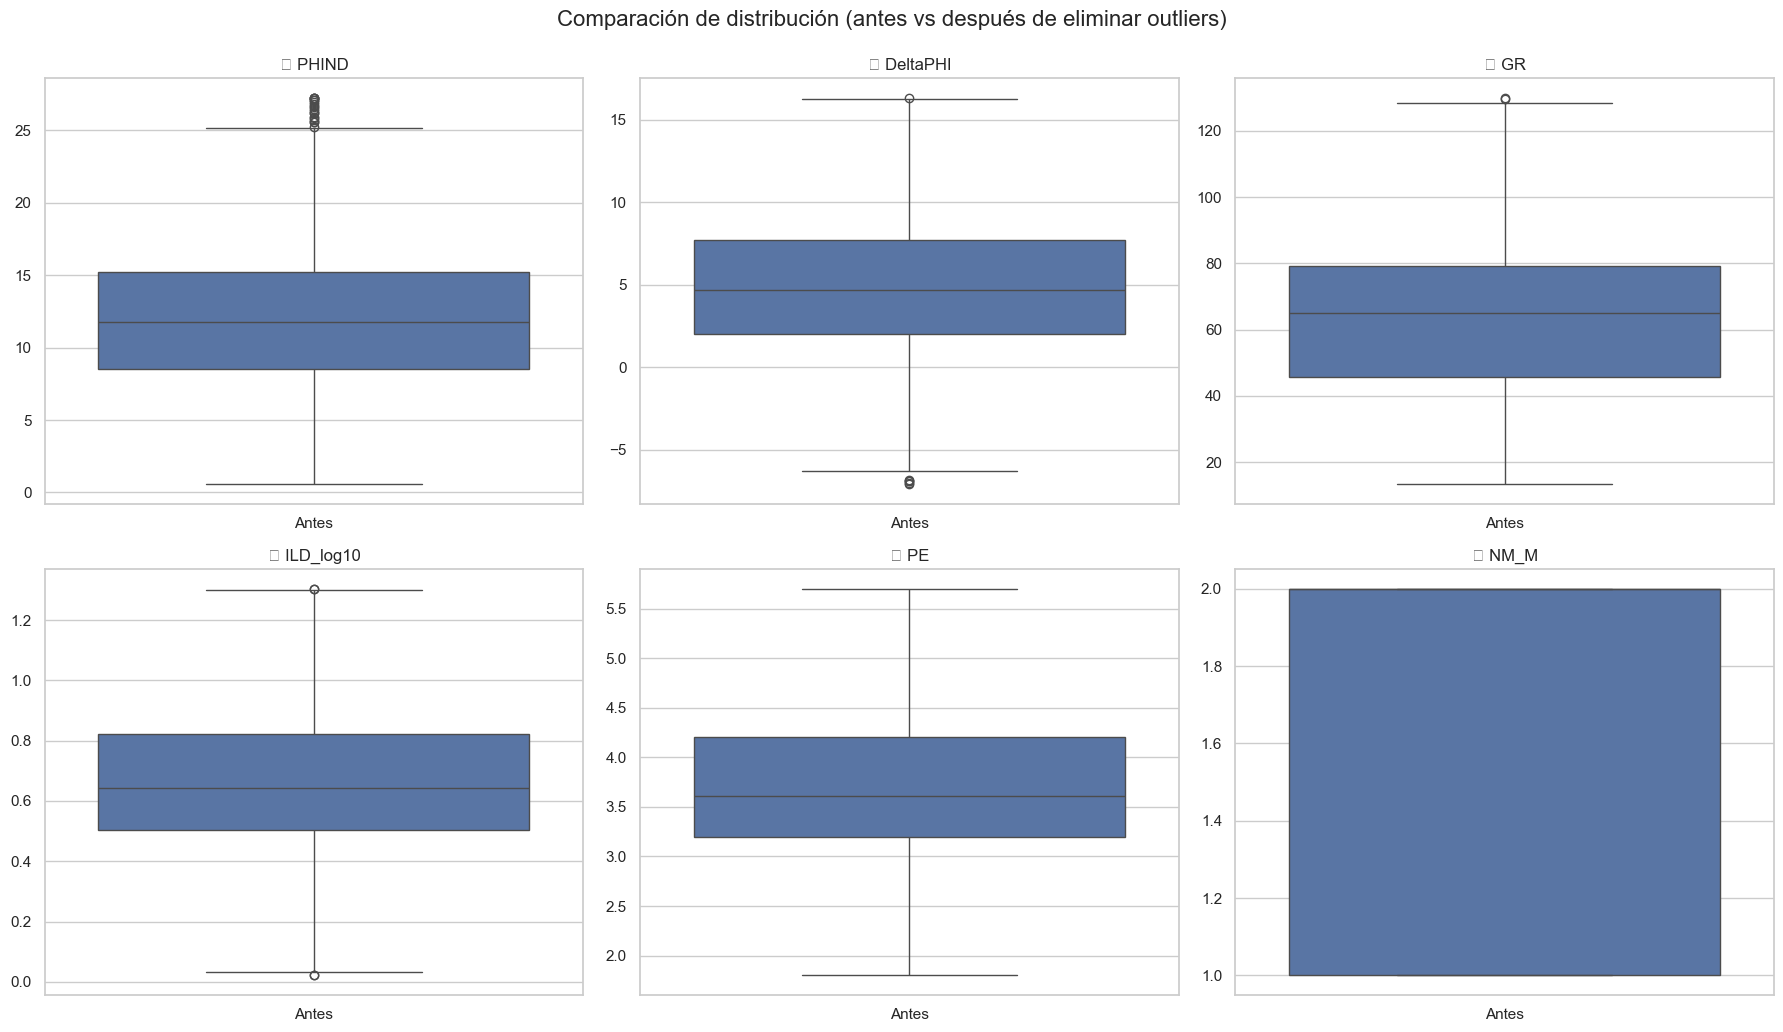

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURACIÓN ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- DETECCIÓN DE OUTLIERS CON IQR ---
def detectar_outliers_iqr(df, factor=1.5):
    outlier_counts = {}
    mask_total = pd.Series([False] * len(df), index=df.index)

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = (df[col] < lower) | (df[col] > upper)
        outlier_counts[col] = mask.sum()
        mask_total |= mask

    total_outliers = mask_total.sum()
    print(f"🔎 Filas con al menos un outlier: {total_outliers} de {len(df)} totales ({100 * total_outliers / len(df):.2f}%)")
    return outlier_counts, ~mask_total

# --- INFORME Y LIMPIEZA ---
print("📊 Informe de outliers:\n")
outlier_info, mask_sin_outliers = detectar_outliers_iqr(X_train.copy())  # o tu df original

# Mostrar cantidad de outliers por columna
outlier_df = pd.DataFrame.from_dict(outlier_info, orient='index', columns=['outliers'])
outlier_df = outlier_df.sort_values('outliers', ascending=False)
display(outlier_df)

# --- LIMPIEZA ---
X_y_train = pd.concat([X_train, y_train], axis=1)
df = X_y_train[mask_sin_outliers].reset_index(drop=True)  # este es el nuevo df limpio
print(f"\n✅ Dataset limpio: {df.shape[0]} filas restantes de {X_train.shape[0]} originales")

# --- BOXPLOTS DE COMPARACIÓN ---
features_mostrar = outlier_df.head(6).index.tolist()  # solo las 6 con más outliers

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(features_mostrar):
    sns.boxplot(data=[X_train[col], df[col]], ax=axes[i])
    axes[i].set_xticklabels(['Antes', 'Después'])
    axes[i].set_title(f'📦 {col}')

plt.tight_layout()
plt.suptitle("Comparación de distribución (antes vs después de eliminar outliers)", fontsize=16, y=1.03)
plt.show()


## 🔀 División del dataset

Se separan las variables predictoras (`X`) del objetivo (`y`) y se divide el conjunto de datos en tres subconjuntos: entrenamiento (70%), validación (15%) y prueba (15%). Para preservar la distribución original de clases en cada conjunto, se utiliza la opción `stratify` en `train_test_split`. Esto es especialmente importante en datasets desbalanceados, como es el caso de las facies.

In [43]:
# Separar features (X) y target (y)
X = df.drop(columns=['Facies'])
y = df['Facies']

# Dividir en train y temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y) # Con stratify para mantener la distribución de clases (Asi todas se ven representadas en la muestra de entrenamiento)

# Dividir temp en val y test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Confirmar tamaños
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 1774, Validation: 380, Test: 381


## ⚙️ Estandarización de los datos

Se aplica una transformación estándar a las variables predictoras mediante `StandardScaler`, lo que garantiza que cada feature tenga media 0 y desviación estándar 1. Esta normalización es importante para el buen desempeño de modelos basados en gradiente, como las redes neuronales. La transformación se ajusta únicamente sobre el conjunto de entrenamiento y luego se aplica al de validación y prueba, evitando así la fuga de datos.

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 🔍 Creación de ventanas deslizantes (sliding windows)

Esta función transforma los datos de entrada en ventanas secuenciales de tamaño fijo (`window_size`) para capturar la información contextual alrededor de cada punto. 

- Cada ventana contiene una sub-secuencia de las muestras de `X` con forma `(window_size, n_features)`.
- La etiqueta asignada a cada ventana corresponde a la clase (`Facies`) del punto central dentro de esa ventana, permitiendo que el modelo aprenda a clasificar con contexto.

Este enfoque es útil para problemas donde la información local (contexto alrededor de cada muestra) mejora la predicción, como en perfiles de pozo o series temporales.

In [45]:
def crear_ventanas_array(X, y, window_size=20, step=1):
    """
    Crea ventanas deslizantes a partir de arrays X (n_samples, n_features) y etiquetas y (n_samples,)
    Retorna ventanas con shape (n_ventanas, window_size, n_features) y etiquetas para la ventana (facies central)
    """
    X_windows = []
    y_windows = []
    n_samples = X.shape[0]
    
    for start in range(0, n_samples - window_size + 1, step):
        end = start + window_size
        X_windows.append(X[start:end])
        y_windows.append(y[start + window_size // 2])
    
    return np.array(X_windows), np.array(y_windows)


## 🔲 Creación de ventanas deslizantes con contexto local

Se generan ventanas solapadas de tamaño fijo (`window_size`) que recorren las muestras escaladas con un paso (`step`) definido. Esto permite que el modelo de CNN 1D tenga acceso a la información contextual alrededor de cada punto, mejorando la capacidad de identificar patrones relacionados con las facies.

La etiqueta asignada a cada ventana corresponde a la clase del punto central, permitiendo que el modelo aprenda a clasificar con base en el entorno local.

Se imprime la forma de los arrays resultantes para verificar que las ventanas y las etiquetas se crearon correctamente, y se confirma la presencia de todas las clases en el conjunto de entrenamiento.


In [46]:
window_size = 10
step = 1

X_train_win, y_train_win = crear_ventanas_array(X_train_scaled, y_train.values, window_size, step)
X_val_win, y_val_win = crear_ventanas_array(X_val_scaled, y_val.values, window_size, step)
X_test_win, y_test_win = crear_ventanas_array(X_test_scaled, y_test.values, window_size, step)

print(f"Ventanas Train: {X_train_win.shape}, etiquetas: {y_train_win.shape}")
print(f"Ventanas Val: {X_val_win.shape}, etiquetas: {y_val_win.shape}")
print(f"Ventanas Test: {X_test_win.shape}, etiquetas: {y_test_win.shape}")

# Verificar clases únicas en y_train_win para definir num_classes
print("Clases únicas en y_train_win:", np.unique(y_train_win))


Ventanas Train: (1765, 10, 6), etiquetas: (1765,)
Ventanas Val: (371, 10, 6), etiquetas: (371,)
Ventanas Test: (372, 10, 6), etiquetas: (372,)
Clases únicas en y_train_win: [1 2 3 4 5 6 7 8 9]


## 🧠 Arquitectura de la CNN 1D para clasificación de facies

Se define un modelo secuencial que toma como entrada ventanas de perfilaje de pozo de tamaño fijo y múltiples características (por ejemplo, curvas de registros geofísicos). La red está compuesta por las siguientes capas:

1. **Conv1D (32 filtros, kernel 3, ReLU)**  
   Extrae patrones locales a lo largo de la dimensión vertical (profundidad o tiempo) combinando todas las features simultáneamente. Cada filtro analiza bloques de 3 pasos consecutivos.

2. **MaxPooling1D (pool size 2)**  
   Reduce la longitud de la secuencia a la mitad, quedándose con la activación máxima de cada par de pasos. Esto resalta los patrones más fuertes y mejora la generalización.

3. **Conv1D (64 filtros, kernel 3, ReLU)**  
   Segunda capa convolucional, más profunda, capaz de aprender patrones más abstractos a partir de los mapas de activación de la primera etapa.

4. **MaxPooling1D (pool size 2)**  
   Nueva reducción secuencial para condensar la información más relevante.

5. **Flatten**  
   Aplana la salida en un vector 1D para conectarlo con las capas densas.

6. **Dense (100 neuronas, ReLU)**  
   Capa totalmente conectada que permite aprender combinaciones no lineales de los patrones extraídos.

7. **Dropout (rate = 0.5)**  
   Regularización para evitar sobreajuste: durante el entrenamiento, desactiva aleatoriamente el 50% de las neuronas.

8. **Dense de salida (`num_classes`, softmax)**  
   Capa final de clasificación, con tantas neuronas como clases de facies. Usa softmax para producir una distribución de probabilidades sobre las clases.

El modelo se compila con el optimizador **Adam** y la función de pérdida `sparse_categorical_crossentropy`, adecuada para problemas de clasificación multiclase con etiquetas codificadas como enteros.


### Pesos

In [47]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_win),
    y=y_train_win
)
class_weights_dict = dict(zip(np.unique(y_train_win), class_weights))

print("Pesos por clase:", class_weights_dict)


Pesos por clase: {np.int64(1): np.float64(1.620752984389348), np.int64(2): np.float64(0.4560723514211886), np.int64(3): np.float64(0.6387984075280492), np.int64(4): np.float64(1.6619585687382297), np.int64(5): np.float64(1.4856902356902357), np.int64(6): np.float64(0.740041928721174), np.int64(7): np.float64(3.214936247723133), np.int64(8): np.float64(0.6785851595540177), np.int64(9): np.float64(4.669312169312169)}


In [48]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling1D, Activation, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from sklearn.utils import class_weight

# --------------------------------------------------------------------------------------------------------
# FIJAR SEMILLA PARA REPRODUCIBILIDAD
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
# --------------------------------------------------------------------------------------------------------

# Parámetros fijos de ventana
window_size = 20
step = 1

# Crear ventanas para train, val y test
X_train_win, y_train_win = crear_ventanas_array(X_train_scaled, y_train.values, window_size, step)
X_val_win, y_val_win = crear_ventanas_array(X_val_scaled, y_val.values, window_size, step)
X_test_win, y_test_win = crear_ventanas_array(X_test_scaled, y_test.values, window_size, step)

print(f"Ventanas Train: {X_train_win.shape}, etiquetas: {y_train_win.shape}")
print(f"Ventanas Val: {X_val_win.shape}, etiquetas: {y_val_win.shape}")
print(f"Ventanas Test: {X_test_win.shape}, etiquetas: {y_test_win.shape}")

# Número de features y clases
n_features = X_train_win.shape[2]
num_classes = int(np.max(y_train_win)) + 1

print("Clases únicas en y_train_win:", np.unique(y_train_win))

# Calcular pesos de clase para balancear desbalance de clases
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_win),
    y=y_train_win
)
class_weights_dict = dict(enumerate(class_weights_array))
print("Pesos de clase calculados:", class_weights_dict)

# Función que construye y entrena modelo con 3 capas Conv1D y hiperparámetros variables y pesos de clase
def crear_entrenar_modelo(
    filters1=32, filters2=64, filters3=128, kernel_size=3, dense_units=100,
    dropout_rate=0.5, dropout_rate_conv=0.2, dropout_rate_conv2=0.2, learning_rate=0.001,
    epochs=20, batch_size=32, use_batchnorm=False, use_global_pooling=False,
    activation='relu', l2_reg=0.0, pool_size=2, optimizer='adam',
    use_early_stopping=False, class_weights=None
):
    model = Sequential()
    
    # Primera capa Conv1D
    model.add(Conv1D(filters1, kernel_size=kernel_size, padding='same',
                     kernel_regularizer=l2(l2_reg),
                     input_shape=(window_size, n_features)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if activation == 'relu':
        model.add(Activation('relu'))
    elif activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'elu':
        model.add(Activation('elu'))
    elif activation == 'selu':
        model.add(Activation('selu'))
    else:
        raise ValueError("activation debe ser 'relu', 'leakyrelu', 'elu' o 'selu'")
    model.add(Dropout(dropout_rate_conv))
    model.add(MaxPooling1D(pool_size))
    
    # Segunda capa Conv1D
    model.add(Conv1D(filters2, kernel_size=kernel_size, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if activation == 'relu':
        model.add(Activation('relu'))
    elif activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'elu':
        model.add(Activation('elu'))
    elif activation == 'selu':
        model.add(Activation('selu'))
    model.add(Dropout(dropout_rate_conv))
    model.add(MaxPooling1D(pool_size))
    
    # Tercera capa Conv1D (nueva)
    model.add(Conv1D(filters3, kernel_size=kernel_size, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if activation == 'relu':
        model.add(Activation('relu'))
    elif activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'elu':
        model.add(Activation('elu'))
    elif activation == 'selu':
        model.add(Activation('selu'))
    model.add(Dropout(dropout_rate_conv2))
    model.add(MaxPooling1D(pool_size))
    
    # Pooling final
    if use_global_pooling:
        model.add(GlobalAveragePooling1D())
    else:
        model.add(Flatten())
    
    model.add(Dense(dense_units))
    if use_batchnorm:
        model.add(BatchNormalization())
    if activation == 'relu':
        model.add(Activation('relu'))
    elif activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'elu':
        model.add(Activation('elu'))
    elif activation == 'selu':
        model.add(Activation('selu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        raise ValueError("optimizer debe ser 'adam', 'rmsprop' o 'nadam'")
    
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    callbacks = []
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True))
    
    history = model.fit(
        X_train_win, y_train_win,
        validation_data=(X_val_win, y_val_win),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks if callbacks else None,
        class_weight=class_weights
    )
    
    val_acc = history.history['val_accuracy'][-1]
    print(f"Validación accuracy final: {val_acc:.4f}")
    
    return model, val_acc

# Ejemplo de búsqueda random simple con 15 configuraciones, añadiendo filtros para 3ra capa y dropout adicional
import random

param_grid = {
    'filters1': [16, 32, 64, 96],
    'filters2': [32, 64, 128, 192],
    'filters3': [64, 128, 192, 256],  # nueva capa más profunda
    'kernel_size': [3, 5, 7],
    'dense_units': [50, 100, 150, 200],
    'dropout_rate': [0.3, 0.5, 0.7],
    'dropout_rate_conv': [0.1, 0.2, 0.3],
    'dropout_rate_conv2': [0.1, 0.2, 0.3],  # dropout para capa 3
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'epochs': [50],
    'batch_size': [32, 64],
    'use_batchnorm': [True, False],
    'use_global_pooling': [True, False],
    'activation': ['relu', 'leakyrelu', 'elu', 'selu'],
    'l2_reg': [0.0, 1e-4, 1e-3],
    'pool_size': [2],
    'optimizer': ['adam', 'rmsprop', 'nadam'],
    'use_early_stopping': [True, False]
}

best_acc = 0
best_params = None
best_model = None

for i in range(15):
    params = {k: random.choice(v) for k,v in param_grid.items()}
    print(f"\n=== Prueba {i+1} con parámetros: {params} ===")
    model, val_acc = crear_entrenar_modelo(**params, class_weights=class_weights_dict)
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

print(f"\nMejor accuracy de validación: {best_acc:.4f} con parámetros: {best_params}")


Ventanas Train: (1755, 20, 6), etiquetas: (1755,)
Ventanas Val: (361, 20, 6), etiquetas: (361,)
Ventanas Test: (362, 20, 6), etiquetas: (362,)
Clases únicas en y_train_win: [1 2 3 4 5 6 7 8 9]
Pesos de clase calculados: {0: np.float64(1.6115702479338843), 1: np.float64(0.45774647887323944), 2: np.float64(0.6351791530944625), 3: np.float64(1.6956521739130435), 4: np.float64(1.4772727272727273), 5: np.float64(0.7386363636363636), 6: np.float64(3.19672131147541), 7: np.float64(0.6794425087108014), 8: np.float64(4.642857142857143)}

=== Prueba 1 con parámetros: {'filters1': 16, 'filters2': 32, 'filters3': 192, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.3, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.0001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': True} ===


c:\Users\andre\anaconda3\envs\sismica\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/07/02 15:58:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '917a894ee986492790276b2065a64804', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
28/28 - 3s - 99ms/step - accuracy: 0.0980 - loss: 5.5478 - val_accuracy: 0.1191 - val_loss: 2.3252
Epoch 2/50
28/28 - 0s - 13ms/step - accuracy: 0.0877 - loss: 5.5360 - val_accuracy: 0.0526 - val_loss: 2.3465
Epoch 3/50
28/28 - 0s - 13ms/step - accuracy: 0.1037 - loss: 5.1254 - val_accuracy: 0.0499 - val_loss: 2.3506
Epoch 4/50
28/28 - 0s - 12ms/step - accuracy: 0.1179 - loss: 4.8580 - val_accuracy: 0.0831 - val_loss: 2.3401
Epoch 5/50
28/28 - 0s - 12ms/step - accuracy: 0.1208 - loss: 4.8184 - val_accuracy: 0.1136 - val_loss: 2.3207
Epoch 6/50
28/28 - 0s - 14ms/step - accuracy: 0.1322 - loss: 4.6475 - val_accuracy: 0.1191 - val_loss: 2.3000
Epoch 7/50
28/28 - 0s - 11ms/step - accuracy: 0.1459 - loss: 4.4137 - val_accuracy: 0.1274 - val_loss: 2.2814
Epoch 8/50
28/28 - 0s - 14ms/step - accuracy: 0.1453 - loss: 4.3553 - val_accuracy: 0.1440 - val_loss: 2.2587
Epoch 9/50
28/28 - 0s - 12ms/step - accuracy: 0.1470 - loss: 4.2828 - val_accuracy: 0.1634 - val_loss: 2.2359
Epoch 10/5

2025/07/02 15:58:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 15:58:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f6de34a8f8d4e5aa1b965da2b1ca710', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.1856

=== Prueba 2 con parámetros: {'filters1': 16, 'filters2': 64, 'filters3': 256, 'kernel_size': 5, 'dense_units': 150, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.2, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'elu', 'l2_reg': 0.001, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': False} ===
Epoch 1/50
28/28 - 2s - 75ms/step - accuracy: 0.1755 - loss: 4.9020 - val_accuracy: 0.2936 - val_loss: 2.2617
Epoch 2/50
28/28 - 0s - 9ms/step - accuracy: 0.2980 - loss: 3.5309 - val_accuracy: 0.2881 - val_loss: 2.2096
Epoch 3/50
28/28 - 0s - 9ms/step - accuracy: 0.3504 - loss: 3.0144 - val_accuracy: 0.2936 - val_loss: 2.1561
Epoch 4/50
28/28 - 0s - 9ms/step - accuracy: 0.3704 - loss: 2.7444 - val_accuracy: 0.2992 - val_loss: 2.1205
Epoch 5/50
28/28 - 0s - 9ms/step - accuracy: 0.4074 - loss: 2.4893 - val_accuracy: 0.3324 - val_loss: 2.0229
Epoch 6/50
2

2025/07/02 15:59:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
c:\Users\andre\anaconda3\envs\sismica\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025/07/02 15:59:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b2a3b11d8b1043b6a114aa3434925c3d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.3684

=== Prueba 3 con parámetros: {'filters1': 64, 'filters2': 64, 'filters3': 64, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': False, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': False} ===
Epoch 1/50
28/28 - 1s - 46ms/step - accuracy: 0.1595 - loss: 3.7338 - val_accuracy: 0.1717 - val_loss: 2.2056
Epoch 2/50
28/28 - 0s - 8ms/step - accuracy: 0.1670 - loss: 3.3179 - val_accuracy: 0.1662 - val_loss: 2.1959
Epoch 3/50
28/28 - 0s - 8ms/step - accuracy: 0.1675 - loss: 3.2785 - val_accuracy: 0.1856 - val_loss: 2.1704
Epoch 4/50
28/28 - 0s - 7ms/step - accuracy: 0.1937 - loss: 3.1526 - val_accuracy: 0.1994 - val_loss: 2.1338
Epoch 5/50
28/28 - 0s - 7ms/step - accuracy: 0.2234 - loss: 3.0594 - val_accuracy: 0.2382 - val_loss: 2.1174
Epoch

2025/07/02 15:59:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


Validación accuracy final: 0.4155

=== Prueba 4 con parámetros: {'filters1': 96, 'filters2': 128, 'filters3': 128, 'kernel_size': 7, 'dense_units': 150, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.0005, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'elu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': False} ===


2025/07/02 15:59:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a8a5bffb961045299409322407a33e11', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
28/28 - 2s - 61ms/step - accuracy: 0.1681 - loss: 4.5954 - val_accuracy: 0.2410 - val_loss: 2.1890
Epoch 2/50
28/28 - 0s - 11ms/step - accuracy: 0.2940 - loss: 3.3228 - val_accuracy: 0.3102 - val_loss: 2.0592
Epoch 3/50
28/28 - 0s - 11ms/step - accuracy: 0.3578 - loss: 2.6607 - val_accuracy: 0.3324 - val_loss: 1.9134
Epoch 4/50
28/28 - 0s - 11ms/step - accuracy: 0.4325 - loss: 2.1553 - val_accuracy: 0.3158 - val_loss: 1.8277
Epoch 5/50
28/28 - 0s - 11ms/step - accuracy: 0.4803 - loss: 1.8679 - val_accuracy: 0.3463 - val_loss: 1.7704
Epoch 6/50
28/28 - 0s - 11ms/step - accuracy: 0.5134 - loss: 1.5790 - val_accuracy: 0.3324 - val_loss: 1.8015
Epoch 7/50
28/28 - 0s - 11ms/step - accuracy: 0.5436 - loss: 1.3838 - val_accuracy: 0.3906 - val_loss: 1.6519
Epoch 8/50
28/28 - 0s - 11ms/step - accuracy: 0.5772 - loss: 1.2343 - val_accuracy: 0.3934 - val_loss: 1.7502
Epoch 9/50
28/28 - 0s - 11ms/step - accuracy: 0.6308 - loss: 1.0655 - val_accuracy: 0.3795 - val_loss: 1.6352
Epoch 10/5

2025/07/02 15:59:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 15:59:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e3a9b236b3f4df7af025a24d0cb0bf7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.4127

=== Prueba 5 con parámetros: {'filters1': 96, 'filters2': 128, 'filters3': 128, 'kernel_size': 3, 'dense_units': 200, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'selu', 'l2_reg': 0.001, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': False} ===
Epoch 1/50
28/28 - 3s - 92ms/step - accuracy: 0.1487 - loss: 5.6515 - val_accuracy: 0.2576 - val_loss: 2.3912
Epoch 2/50
28/28 - 0s - 10ms/step - accuracy: 0.2900 - loss: 3.9467 - val_accuracy: 0.3019 - val_loss: 2.2410
Epoch 3/50
28/28 - 0s - 10ms/step - accuracy: 0.3652 - loss: 3.1461 - val_accuracy: 0.3380 - val_loss: 2.1090
Epoch 4/50
28/28 - 0s - 11ms/step - accuracy: 0.4057 - loss: 2.6827 - val_accuracy: 0.3435 - val_loss: 2.1109
Epoch 5/50
28/28 - 0s - 10ms/step - accuracy: 0.4627 - loss: 2.3035 - val_accuracy: 0.3546 - val_loss: 2.0926
Epoch

2025/07/02 15:59:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 15:59:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '27bae117e3ec4b92b29106c08305870b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.3795

=== Prueba 6 con parámetros: {'filters1': 64, 'filters2': 32, 'filters3': 192, 'kernel_size': 5, 'dense_units': 100, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.3, 'learning_rate': 0.0001, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True} ===


Epoch 1/50
55/55 - 2s - 40ms/step - accuracy: 0.1271 - loss: 5.3435 - val_accuracy: 0.1191 - val_loss: 2.2632
Epoch 2/50
55/55 - 0s - 8ms/step - accuracy: 0.1419 - loss: 4.9631 - val_accuracy: 0.1967 - val_loss: 2.2369
Epoch 3/50
55/55 - 0s - 9ms/step - accuracy: 0.1521 - loss: 4.6573 - val_accuracy: 0.2161 - val_loss: 2.2134
Epoch 4/50
55/55 - 1s - 9ms/step - accuracy: 0.1715 - loss: 4.4692 - val_accuracy: 0.2022 - val_loss: 2.1870
Epoch 5/50
55/55 - 1s - 10ms/step - accuracy: 0.1937 - loss: 4.1977 - val_accuracy: 0.2133 - val_loss: 2.1696
Epoch 6/50
55/55 - 0s - 8ms/step - accuracy: 0.1966 - loss: 4.0911 - val_accuracy: 0.2382 - val_loss: 2.1482
Epoch 7/50
55/55 - 0s - 8ms/step - accuracy: 0.2097 - loss: 3.9736 - val_accuracy: 0.2244 - val_loss: 2.1328
Epoch 8/50
55/55 - 0s - 8ms/step - accuracy: 0.2103 - loss: 3.9339 - val_accuracy: 0.2382 - val_loss: 2.1339
Epoch 9/50
55/55 - 0s - 8ms/step - accuracy: 0.2256 - loss: 3.7246 - val_accuracy: 0.2327 - val_loss: 2.1230
Epoch 10/50
55/55

2025/07/02 16:00:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:00:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4e5d9fed57284f7884d4c0ffc268cf16', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.3047

=== Prueba 7 con parámetros: {'filters1': 32, 'filters2': 32, 'filters3': 64, 'kernel_size': 7, 'dense_units': 200, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.3, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.001, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': False} ===
Epoch 1/50
55/55 - 2s - 28ms/step - accuracy: 0.1573 - loss: 3.3883 - val_accuracy: 0.1662 - val_loss: 2.2157
Epoch 2/50
55/55 - 0s - 5ms/step - accuracy: 0.1789 - loss: 3.2264 - val_accuracy: 0.2022 - val_loss: 2.1661
Epoch 3/50
55/55 - 0s - 5ms/step - accuracy: 0.2251 - loss: 3.1067 - val_accuracy: 0.2327 - val_loss: 2.1092
Epoch 4/50
55/55 - 0s - 5ms/step - accuracy: 0.2348 - loss: 3.0403 - val_accuracy: 0.2465 - val_loss: 2.0278
Epoch 5/50
55/55 - 0s - 5ms/step - accuracy: 0.2724 - loss: 2.8889 - val_accuracy: 0.2770 - val_loss: 1.9555
Epoch

2025/07/02 16:00:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


Validación accuracy final: 0.3767

=== Prueba 8 con parámetros: {'filters1': 64, 'filters2': 32, 'filters3': 128, 'kernel_size': 7, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.3, 'learning_rate': 0.0001, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'elu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': False} ===


2025/07/02 16:00:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7567ca76ba2d49e7acbf4bef4d0cfe81', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
55/55 - 2s - 31ms/step - accuracy: 0.0866 - loss: 5.5787 - val_accuracy: 0.1468 - val_loss: 2.2865
Epoch 2/50
55/55 - 0s - 6ms/step - accuracy: 0.1311 - loss: 5.1094 - val_accuracy: 0.1607 - val_loss: 2.3644
Epoch 3/50
55/55 - 0s - 6ms/step - accuracy: 0.1510 - loss: 4.8097 - val_accuracy: 0.1717 - val_loss: 2.3833
Epoch 4/50
55/55 - 0s - 6ms/step - accuracy: 0.1396 - loss: 4.5951 - val_accuracy: 0.1801 - val_loss: 2.3707
Epoch 5/50
55/55 - 0s - 6ms/step - accuracy: 0.1613 - loss: 4.4487 - val_accuracy: 0.1911 - val_loss: 2.3294
Epoch 6/50
55/55 - 0s - 6ms/step - accuracy: 0.1943 - loss: 4.2835 - val_accuracy: 0.2105 - val_loss: 2.3051
Epoch 7/50
55/55 - 0s - 6ms/step - accuracy: 0.2051 - loss: 4.0518 - val_accuracy: 0.2271 - val_loss: 2.2755
Epoch 8/50
55/55 - 0s - 6ms/step - accuracy: 0.2211 - loss: 3.8767 - val_accuracy: 0.2216 - val_loss: 2.2319
Epoch 9/50
55/55 - 0s - 6ms/step - accuracy: 0.2336 - loss: 3.8134 - val_accuracy: 0.2355 - val_loss: 2.2030
Epoch 10/50
55/55 

2025/07/02 16:00:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


Validación accuracy final: 0.3241

=== Prueba 9 con parámetros: {'filters1': 32, 'filters2': 32, 'filters3': 64, 'kernel_size': 7, 'dense_units': 200, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.2, 'dropout_rate_conv2': 0.2, 'learning_rate': 0.0005, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'elu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True} ===


2025/07/02 16:00:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28734169cdaf47409dd0d44a8258c353', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
55/55 - 2s - 39ms/step - accuracy: 0.1128 - loss: 5.6675 - val_accuracy: 0.1773 - val_loss: 2.2596
Epoch 2/50
55/55 - 0s - 8ms/step - accuracy: 0.1613 - loss: 4.6078 - val_accuracy: 0.2493 - val_loss: 2.1738
Epoch 3/50
55/55 - 0s - 8ms/step - accuracy: 0.1994 - loss: 4.0407 - val_accuracy: 0.2659 - val_loss: 2.0997
Epoch 4/50
55/55 - 0s - 8ms/step - accuracy: 0.2085 - loss: 3.9094 - val_accuracy: 0.2853 - val_loss: 2.0811
Epoch 5/50
55/55 - 0s - 8ms/step - accuracy: 0.2279 - loss: 3.6887 - val_accuracy: 0.2909 - val_loss: 2.0470
Epoch 6/50
55/55 - 0s - 9ms/step - accuracy: 0.2604 - loss: 3.4392 - val_accuracy: 0.3075 - val_loss: 2.0665
Epoch 7/50
55/55 - 0s - 8ms/step - accuracy: 0.2644 - loss: 3.3693 - val_accuracy: 0.3019 - val_loss: 2.0037
Epoch 8/50
55/55 - 0s - 8ms/step - accuracy: 0.2849 - loss: 3.1991 - val_accuracy: 0.3019 - val_loss: 2.0282
Epoch 9/50
55/55 - 1s - 12ms/step - accuracy: 0.2934 - loss: 3.1352 - val_accuracy: 0.3102 - val_loss: 2.0101
Epoch 10/50
55/55

2025/07/02 16:01:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Validación accuracy final: 0.3546

=== Prueba 10 con parámetros: {'filters1': 16, 'filters2': 32, 'filters3': 64, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'dropout_rate_conv2': 0.2, 'learning_rate': 0.0005, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'selu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': False} ===


2025/07/02 16:01:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6cfe94ef53bb4a9e8fb5d896befc768d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
28/28 - 2s - 57ms/step - accuracy: 0.1219 - loss: 5.8264 - val_accuracy: 0.1302 - val_loss: 2.3749
Epoch 2/50
28/28 - 0s - 8ms/step - accuracy: 0.1191 - loss: 5.3033 - val_accuracy: 0.1607 - val_loss: 2.3107
Epoch 3/50
28/28 - 0s - 7ms/step - accuracy: 0.1670 - loss: 4.8510 - val_accuracy: 0.1662 - val_loss: 2.3001
Epoch 4/50
28/28 - 0s - 8ms/step - accuracy: 0.1590 - loss: 4.5563 - val_accuracy: 0.1801 - val_loss: 2.2930
Epoch 5/50
28/28 - 0s - 7ms/step - accuracy: 0.1487 - loss: 4.5201 - val_accuracy: 0.1856 - val_loss: 2.2623
Epoch 6/50
28/28 - 0s - 8ms/step - accuracy: 0.1692 - loss: 4.3075 - val_accuracy: 0.1856 - val_loss: 2.2515
Epoch 7/50
28/28 - 0s - 7ms/step - accuracy: 0.1909 - loss: 4.1766 - val_accuracy: 0.1745 - val_loss: 2.2342
Epoch 8/50
28/28 - 0s - 7ms/step - accuracy: 0.1989 - loss: 3.9678 - val_accuracy: 0.1884 - val_loss: 2.2241
Epoch 9/50
28/28 - 0s - 7ms/step - accuracy: 0.1892 - loss: 3.9175 - val_accuracy: 0.1994 - val_loss: 2.1995
Epoch 10/50
28/28 

2025/07/02 16:01:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 16:01:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '16893e9cde4c4e85bd0add547b8e5d92', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.2992

=== Prueba 11 con parámetros: {'filters1': 32, 'filters2': 32, 'filters3': 64, 'kernel_size': 7, 'dense_units': 150, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.3, 'learning_rate': 0.0005, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.001, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': True} ===


Epoch 1/50
55/55 - 3s - 46ms/step - accuracy: 0.1088 - loss: 5.5200 - val_accuracy: 0.1717 - val_loss: 2.3479
Epoch 2/50
55/55 - 0s - 8ms/step - accuracy: 0.1897 - loss: 3.9196 - val_accuracy: 0.1828 - val_loss: 2.2879
Epoch 3/50
55/55 - 0s - 8ms/step - accuracy: 0.1977 - loss: 3.5629 - val_accuracy: 0.1690 - val_loss: 2.2194
Epoch 4/50
55/55 - 1s - 12ms/step - accuracy: 0.2256 - loss: 3.3044 - val_accuracy: 0.2105 - val_loss: 2.1574
Epoch 5/50
55/55 - 0s - 9ms/step - accuracy: 0.2462 - loss: 3.2054 - val_accuracy: 0.2355 - val_loss: 2.1268
Epoch 6/50
55/55 - 1s - 11ms/step - accuracy: 0.2444 - loss: 3.1417 - val_accuracy: 0.2659 - val_loss: 2.0913
Epoch 7/50
55/55 - 0s - 8ms/step - accuracy: 0.2718 - loss: 3.0668 - val_accuracy: 0.2632 - val_loss: 2.0609
Epoch 8/50
55/55 - 0s - 8ms/step - accuracy: 0.2849 - loss: 2.9217 - val_accuracy: 0.2964 - val_loss: 2.0246
Epoch 9/50
55/55 - 0s - 8ms/step - accuracy: 0.3003 - loss: 2.8747 - val_accuracy: 0.2992 - val_loss: 2.0386
Epoch 10/50
55/5

2025/07/02 16:01:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:02:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86a6d00a44de484c8519a0e6bb591ca3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.3407

=== Prueba 12 con parámetros: {'filters1': 64, 'filters2': 128, 'filters3': 128, 'kernel_size': 7, 'dense_units': 150, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'dropout_rate_conv2': 0.2, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True} ===


Epoch 1/50
28/28 - 1s - 48ms/step - accuracy: 0.1493 - loss: 3.4336 - val_accuracy: 0.1634 - val_loss: 2.1900
Epoch 2/50
28/28 - 0s - 13ms/step - accuracy: 0.1647 - loss: 3.2251 - val_accuracy: 0.1634 - val_loss: 2.1388
Epoch 3/50
28/28 - 0s - 13ms/step - accuracy: 0.1726 - loss: 3.1491 - val_accuracy: 0.1994 - val_loss: 2.1084
Epoch 4/50
28/28 - 0s - 13ms/step - accuracy: 0.1943 - loss: 3.0712 - val_accuracy: 0.2659 - val_loss: 2.0501
Epoch 5/50
28/28 - 0s - 12ms/step - accuracy: 0.2655 - loss: 2.8682 - val_accuracy: 0.3130 - val_loss: 1.8873
Epoch 6/50
28/28 - 0s - 13ms/step - accuracy: 0.3117 - loss: 2.6077 - val_accuracy: 0.3047 - val_loss: 1.7209
Epoch 7/50
28/28 - 0s - 13ms/step - accuracy: 0.3521 - loss: 2.3966 - val_accuracy: 0.3435 - val_loss: 1.6925
Epoch 8/50
28/28 - 0s - 13ms/step - accuracy: 0.3840 - loss: 2.1850 - val_accuracy: 0.3269 - val_loss: 1.6378
Epoch 9/50
28/28 - 0s - 13ms/step - accuracy: 0.3915 - loss: 2.0943 - val_accuracy: 0.3518 - val_loss: 1.5911
Epoch 10/5

2025/07/02 16:02:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:02:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '956dc2354a174712a430af8f200fbad1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.3546

=== Prueba 13 con parámetros: {'filters1': 64, 'filters2': 32, 'filters3': 192, 'kernel_size': 7, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'elu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': False} ===
Epoch 1/50
28/28 - 3s - 118ms/step - accuracy: 0.1595 - loss: 3.3546 - val_accuracy: 0.1634 - val_loss: 2.1907
Epoch 2/50
28/28 - 0s - 9ms/step - accuracy: 0.1801 - loss: 3.1464 - val_accuracy: 0.2022 - val_loss: 2.1190
Epoch 3/50
28/28 - 0s - 8ms/step - accuracy: 0.2262 - loss: 3.0164 - val_accuracy: 0.2576 - val_loss: 2.0359
Epoch 4/50
28/28 - 0s - 8ms/step - accuracy: 0.2575 - loss: 2.8257 - val_accuracy: 0.2992 - val_loss: 1.9446
Epoch 5/50
28/28 - 0s - 8ms/step - accuracy: 0.3077 - loss: 2.6498 - val_accuracy: 0.3047 - val_loss: 1.8359
Epoch 6/50
2

2025/07/02 16:02:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


Validación accuracy final: 0.4238

=== Prueba 14 con parámetros: {'filters1': 64, 'filters2': 64, 'filters3': 192, 'kernel_size': 3, 'dense_units': 200, 'dropout_rate': 0.7, 'dropout_rate_conv': 0.3, 'dropout_rate_conv2': 0.2, 'learning_rate': 0.0001, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True} ===


2025/07/02 16:02:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f58a9d11c3774d5e87f215f6d62d784b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
55/55 - 2s - 34ms/step - accuracy: 0.0877 - loss: 7.5420 - val_accuracy: 0.0776 - val_loss: 2.3400
Epoch 2/50
55/55 - 0s - 9ms/step - accuracy: 0.0997 - loss: 6.9266 - val_accuracy: 0.0720 - val_loss: 2.3547
Epoch 3/50
55/55 - 0s - 9ms/step - accuracy: 0.1105 - loss: 6.4326 - val_accuracy: 0.0942 - val_loss: 2.3309
Epoch 4/50
55/55 - 0s - 9ms/step - accuracy: 0.1265 - loss: 6.0713 - val_accuracy: 0.1108 - val_loss: 2.2928
Epoch 5/50
55/55 - 0s - 9ms/step - accuracy: 0.1259 - loss: 5.7745 - val_accuracy: 0.1496 - val_loss: 2.2616
Epoch 6/50
55/55 - 1s - 10ms/step - accuracy: 0.1447 - loss: 5.4727 - val_accuracy: 0.1717 - val_loss: 2.2463
Epoch 7/50
55/55 - 0s - 9ms/step - accuracy: 0.1493 - loss: 5.1213 - val_accuracy: 0.2022 - val_loss: 2.2469
Epoch 8/50
55/55 - 0s - 8ms/step - accuracy: 0.1556 - loss: 5.1338 - val_accuracy: 0.2022 - val_loss: 2.2556
Epoch 9/50
55/55 - 0s - 9ms/step - accuracy: 0.1641 - loss: 4.7694 - val_accuracy: 0.1884 - val_loss: 2.2724
Epoch 10/50
55/55

2025/07/02 16:02:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:02:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0db54d15783b437a96ae80cd09df01af', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Validación accuracy final: 0.1967

=== Prueba 15 con parámetros: {'filters1': 16, 'filters2': 128, 'filters3': 256, 'kernel_size': 7, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.0005, 'epochs': 50, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': True} ===


Epoch 1/50
55/55 - 2s - 34ms/step - accuracy: 0.1658 - loss: 3.3365 - val_accuracy: 0.1773 - val_loss: 2.1853
Epoch 2/50
55/55 - 1s - 10ms/step - accuracy: 0.2046 - loss: 3.0722 - val_accuracy: 0.2271 - val_loss: 2.1127
Epoch 3/50
55/55 - 1s - 9ms/step - accuracy: 0.2575 - loss: 2.8510 - val_accuracy: 0.2576 - val_loss: 2.0069
Epoch 4/50
55/55 - 1s - 9ms/step - accuracy: 0.3100 - loss: 2.6217 - val_accuracy: 0.2715 - val_loss: 1.9046
Epoch 5/50
55/55 - 1s - 9ms/step - accuracy: 0.3453 - loss: 2.4383 - val_accuracy: 0.2992 - val_loss: 1.8284
Epoch 6/50
55/55 - 1s - 9ms/step - accuracy: 0.3892 - loss: 2.2527 - val_accuracy: 0.3075 - val_loss: 1.7708
Epoch 7/50
55/55 - 0s - 9ms/step - accuracy: 0.3966 - loss: 2.1422 - val_accuracy: 0.3241 - val_loss: 1.7502
Epoch 8/50
55/55 - 1s - 10ms/step - accuracy: 0.4313 - loss: 2.0076 - val_accuracy: 0.3186 - val_loss: 1.7976
Epoch 9/50
55/55 - 1s - 9ms/step - accuracy: 0.4564 - loss: 1.8591 - val_accuracy: 0.3352 - val_loss: 1.7630
Epoch 10/50
55/5

2025/07/02 16:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Validación accuracy final: 0.3380

Mejor accuracy de validación: 0.4238 con parámetros: {'filters1': 64, 'filters2': 32, 'filters3': 192, 'kernel_size': 7, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'dropout_rate_conv2': 0.1, 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 64, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'elu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'nadam', 'use_early_stopping': False}


---

In [51]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling1D, Activation, Flatten, LeakyReLU)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from itertools import combinations

# ------------------------------------------------------------
# FIJAR SEMILLA PARA REPRODUCIBILIDAD
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------------------------------------
# Parámetros fijos de ventana
window_size = 20
step = 1

# ------------------------------------------------------------
# Crear ventanas completas para calcular pesos
X_train_win_full, y_train_win = crear_ventanas_array(X_train_scaled, y_train.values, window_size, step)

# Calcular pesos de clase
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_win),
    y=y_train_win
)
class_weights_dict = dict(enumerate(class_weights_array))
print("Pesos de clase calculados:", class_weights_dict)

# ------------------------------------------------------------
# Parámetros del modelo
param_grid = {
    'filters1': [16, 32, 64],
    'filters2': [32, 64, 128],
    'kernel_size': [3, 5],
    'dense_units': [50, 100],
    'dropout_rate': [0.3, 0.5],
    'dropout_rate_conv': [0.1, 0.2],
    'learning_rate': [1e-3, 5e-4],
    'epochs': [30],
    'batch_size': [32],
    'use_batchnorm': [True, False],
    'use_global_pooling': [True, False],
    'activation': ['relu', 'leakyrelu'],
    'l2_reg': [0.0, 1e-4],
    'pool_size': [2],
    'optimizer': ['adam', 'rmsprop'],
    'use_early_stopping': [True, False]
}

# ------------------------------------------------------------
def crear_entrenar_modelo(
    X_train_win, y_train_win, X_val_win, y_val_win, n_features,
    filters1=32, filters2=64, kernel_size=3, dense_units=100,
    dropout_rate=0.5, dropout_rate_conv=0.2, learning_rate=0.001,
    epochs=20, batch_size=32, use_batchnorm=False, use_global_pooling=False,
    activation='relu', l2_reg=0.0, pool_size=2, optimizer='adam',
    use_early_stopping=False, class_weights=None
):
    model = Sequential()
    
    def add_conv_block(filters):
        model.add(Conv1D(filters, kernel_size=kernel_size, padding='same',
                         kernel_regularizer=l2(l2_reg)))
        if use_batchnorm:
            model.add(BatchNormalization())
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
        model.add(Dropout(dropout_rate_conv))
        model.add(MaxPooling1D(pool_size))

    # Input layer
    model.add(Conv1D(filters1, kernel_size=kernel_size, padding='same',
                     kernel_regularizer=l2(l2_reg),
                     input_shape=(window_size, n_features)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
    model.add(Dropout(dropout_rate_conv))
    model.add(MaxPooling1D(pool_size))

    # Second conv block
    add_conv_block(filters2)

    # Global pooling or flatten
    model.add(GlobalAveragePooling1D() if use_global_pooling else Flatten())

    # Dense block
    model.add(Dense(dense_units))
    if use_batchnorm:
        model.add(BatchNormalization())
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
    model.add(Dropout(dropout_rate))

    # Output
    num_classes = int(np.max(y_train_win)) + 1
    model.add(Dense(num_classes, activation='softmax'))

    # Optimizer
    optimizers = {
        'adam': Adam,
        'rmsprop': RMSprop,
        'nadam': Nadam
    }
    model.compile(
        optimizer=optimizers[optimizer](learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = []
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True))

    history = model.fit(
        X_train_win, y_train_win,
        validation_data=(X_val_win, y_val_win),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks or None,
        class_weight=class_weights
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"✅ Validación accuracy final: {val_acc:.4f}")
    return model, val_acc
# ------------------------------------------------------------

# Iterar sobre combinaciones de features

n_total_features = X_train_scaled.shape[1]
subset_size = int(n_total_features * 0.7)
max_combinations = 20

print(f"\n🔄 Generando {max_combinations} combinaciones de {subset_size}/{n_total_features} features...")
combinaciones_features = list(combinations(range(n_total_features), subset_size))[:max_combinations]

best_acc = 0
best_model = None
best_params = None

for i, selected_idx in enumerate(combinaciones_features):
    print(f"\n=== 🔁 Combinación {i+1}/{len(combinaciones_features)} ===")

    X_train_sub = X_train_scaled[:, selected_idx]
    X_val_sub   = X_val_scaled[:, selected_idx]
    X_test_sub  = X_test_scaled[:, selected_idx]

    X_train_win, y_train_win = crear_ventanas_array(X_train_sub, y_train.values, window_size, step)
    X_val_win, y_val_win     = crear_ventanas_array(X_val_sub, y_val.values, window_size, step)
    X_test_win, y_test_win   = crear_ventanas_array(X_test_sub, y_test.values, window_size, step)

    n_features = X_train_win.shape[2]

    params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"🧪 Parámetros: {params}")

    model, val_acc = crear_entrenar_modelo(
        X_train_win, y_train_win,
        X_val_win, y_val_win,
        n_features=n_features,
        **params,
        class_weights=class_weights_dict
    )

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

print(f"\n🏆 Mejor accuracy de validación: {best_acc:.4f}")
print(f"⚙️  Con parámetros: {best_params}")


c:\Users\andre\anaconda3\envs\sismica\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/07/02 16:20:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7bff11eaef5d4c24ada247f2c84e41e1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Pesos de clase calculados: {0: np.float64(1.6115702479338843), 1: np.float64(0.45774647887323944), 2: np.float64(0.6351791530944625), 3: np.float64(1.6956521739130435), 4: np.float64(1.4772727272727273), 5: np.float64(0.7386363636363636), 6: np.float64(3.19672131147541), 7: np.float64(0.6794425087108014), 8: np.float64(4.642857142857143)}

🔄 Generando 20 combinaciones de 4/6 features...

=== 🔁 Combinación 1/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 32, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True}


Epoch 1/30
55/55 - 1s - 24ms/step - accuracy: 0.1447 - loss: 3.6015 - val_accuracy: 0.1634 - val_loss: 2.2137
Epoch 2/30
55/55 - 0s - 6ms/step - accuracy: 0.1681 - loss: 3.2486 - val_accuracy: 0.1634 - val_loss: 2.2251
Epoch 3/30
55/55 - 0s - 6ms/step - accuracy: 0.1635 - loss: 3.1929 - val_accuracy: 0.1634 - val_loss: 2.2309
Epoch 4/30
55/55 - 0s - 6ms/step - accuracy: 0.1675 - loss: 3.1818 - val_accuracy: 0.1634 - val_loss: 2.2145
Epoch 5/30
55/55 - 0s - 6ms/step - accuracy: 0.1744 - loss: 3.1552 - val_accuracy: 0.1634 - val_loss: 2.2287
Epoch 6/30
55/55 - 0s - 7ms/step - accuracy: 0.1658 - loss: 3.1747 - val_accuracy: 0.1717 - val_loss: 2.2182


2025/07/02 16:20:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Validación accuracy final: 0.1717

=== 🔁 Combinación 2/15 ===
🧪 Parámetros: {'filters1': 32, 'filters2': 32, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.2, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'leakyrelu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': False}


c:\Users\andre\anaconda3\envs\sismica\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025/07/02 16:20:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3876737b3adc463f9936671ea47f622d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
55/55 - 6s - 102ms/step - accuracy: 0.1618 - loss: 4.6687 - val_accuracy: 0.1690 - val_loss: 2.2332
Epoch 2/30
55/55 - 2s - 36ms/step - accuracy: 0.1652 - loss: 3.9414 - val_accuracy: 0.1579 - val_loss: 2.1611
Epoch 3/30
55/55 - 1s - 15ms/step - accuracy: 0.1726 - loss: 3.7029 - val_accuracy: 0.1828 - val_loss: 2.1259
Epoch 4/30
55/55 - 1s - 18ms/step - accuracy: 0.1863 - loss: 3.6318 - val_accuracy: 0.1607 - val_loss: 2.1589
Epoch 5/30
55/55 - 1s - 24ms/step - accuracy: 0.1846 - loss: 3.5047 - val_accuracy: 0.1690 - val_loss: 2.1364
Epoch 6/30
55/55 - 1s - 18ms/step - accuracy: 0.1818 - loss: 3.4708 - val_accuracy: 0.1634 - val_loss: 2.1505
Epoch 7/30
55/55 - 1s - 13ms/step - accuracy: 0.1715 - loss: 3.4516 - val_accuracy: 0.1579 - val_loss: 2.2127
Epoch 8/30
55/55 - 1s - 14ms/step - accuracy: 0.1875 - loss: 3.3548 - val_accuracy: 0.1496 - val_loss: 2.2060
Epoch 9/30
55/55 - 2s - 27ms/step - accuracy: 0.1795 - loss: 3.3286 - val_accuracy: 0.1607 - val_loss: 2.2567
Epoch 10/

2025/07/02 16:21:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


✅ Validación accuracy final: 0.1717

=== 🔁 Combinación 3/15 ===
🧪 Parámetros: {'filters1': 32, 'filters2': 128, 'kernel_size': 5, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'leakyrelu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True}


2025/07/02 16:21:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01a5a8ebff1345128d578aa598992169', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
55/55 - 6s - 108ms/step - accuracy: 0.1447 - loss: 4.8131 - val_accuracy: 0.1579 - val_loss: 2.2144
Epoch 2/30
55/55 - 1s - 18ms/step - accuracy: 0.2103 - loss: 3.6655 - val_accuracy: 0.1801 - val_loss: 2.1253
Epoch 3/30
55/55 - 1s - 22ms/step - accuracy: 0.2217 - loss: 3.3047 - val_accuracy: 0.1828 - val_loss: 2.0744
Epoch 4/30
55/55 - 1s - 17ms/step - accuracy: 0.2199 - loss: 3.1934 - val_accuracy: 0.1607 - val_loss: 2.1296
Epoch 5/30
55/55 - 1s - 21ms/step - accuracy: 0.2501 - loss: 2.9520 - val_accuracy: 0.1579 - val_loss: 2.1753
Epoch 6/30
55/55 - 1s - 17ms/step - accuracy: 0.2598 - loss: 2.9381 - val_accuracy: 0.2244 - val_loss: 2.1156
Epoch 7/30
55/55 - 2s - 30ms/step - accuracy: 0.2718 - loss: 2.8287 - val_accuracy: 0.2078 - val_loss: 2.0725
Epoch 8/30
55/55 - 1s - 19ms/step - accuracy: 0.2860 - loss: 2.7462 - val_accuracy: 0.1828 - val_loss: 2.0884
Epoch 9/30
55/55 - 1s - 17ms/step - accuracy: 0.2849 - loss: 2.7201 - val_accuracy: 0.1994 - val_loss: 2.1138
Epoch 10/

2025/07/02 16:21:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Validación accuracy final: 0.2382

=== 🔁 Combinación 4/15 ===
🧪 Parámetros: {'filters1': 16, 'filters2': 128, 'kernel_size': 3, 'dense_units': 50, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.2, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True}


2025/07/02 16:21:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5ae3610a21014f66904fc4a93b02a521', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
55/55 - 5s - 93ms/step - accuracy: 0.1100 - loss: 5.4749 - val_accuracy: 0.1385 - val_loss: 2.3024
Epoch 2/30
55/55 - 1s - 23ms/step - accuracy: 0.1379 - loss: 4.6954 - val_accuracy: 0.1524 - val_loss: 2.2533
Epoch 3/30
55/55 - 1s - 24ms/step - accuracy: 0.1556 - loss: 4.3125 - val_accuracy: 0.1745 - val_loss: 2.2058
Epoch 4/30
55/55 - 2s - 45ms/step - accuracy: 0.1607 - loss: 3.9894 - val_accuracy: 0.1634 - val_loss: 2.1997
Epoch 5/30
55/55 - 1s - 24ms/step - accuracy: 0.1789 - loss: 3.8338 - val_accuracy: 0.1690 - val_loss: 2.1947
Epoch 6/30
55/55 - 1s - 20ms/step - accuracy: 0.1852 - loss: 3.6429 - val_accuracy: 0.1634 - val_loss: 2.1636
Epoch 7/30
55/55 - 1s - 20ms/step - accuracy: 0.1897 - loss: 3.5753 - val_accuracy: 0.1745 - val_loss: 2.1834
Epoch 8/30
55/55 - 1s - 19ms/step - accuracy: 0.1749 - loss: 3.6040 - val_accuracy: 0.1662 - val_loss: 2.1908
Epoch 9/30
55/55 - 1s - 17ms/step - accuracy: 0.1783 - loss: 3.5509 - val_accuracy: 0.1579 - val_loss: 2.2035
Epoch 10/3

2025/07/02 16:22:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Validación accuracy final: 0.1496

=== 🔁 Combinación 5/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 64, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True}


2025/07/02 16:22:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c0d28d4a66ef4885a62ece1898e06b34', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
55/55 - 5s - 84ms/step - accuracy: 0.1550 - loss: 3.5407 - val_accuracy: 0.1634 - val_loss: 2.2531
Epoch 2/30
55/55 - 1s - 22ms/step - accuracy: 0.1601 - loss: 3.2358 - val_accuracy: 0.1634 - val_loss: 2.2352
Epoch 3/30
55/55 - 1s - 24ms/step - accuracy: 0.1641 - loss: 3.2097 - val_accuracy: 0.1634 - val_loss: 2.2299
Epoch 4/30
55/55 - 1s - 23ms/step - accuracy: 0.1601 - loss: 3.2062 - val_accuracy: 0.1634 - val_loss: 2.2483
Epoch 5/30
55/55 - 1s - 23ms/step - accuracy: 0.1652 - loss: 3.1905 - val_accuracy: 0.1634 - val_loss: 2.2417
Epoch 6/30
55/55 - 1s - 24ms/step - accuracy: 0.1687 - loss: 3.1874 - val_accuracy: 0.1662 - val_loss: 2.2310
Epoch 7/30
55/55 - 1s - 26ms/step - accuracy: 0.1624 - loss: 3.1694 - val_accuracy: 0.1634 - val_loss: 2.2288
Epoch 8/30
55/55 - 3s - 46ms/step - accuracy: 0.1675 - loss: 3.1415 - val_accuracy: 0.1634 - val_loss: 2.2385
Epoch 9/30
55/55 - 1s - 23ms/step - accuracy: 0.1692 - loss: 3.1455 - val_accuracy: 0.1690 - val_loss: 2.2429
Epoch 10/3

2025/07/02 16:22:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Validación accuracy final: 0.1717

=== 🔁 Combinación 6/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 64, 'kernel_size': 5, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'leakyrelu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True}


2025/07/02 16:23:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6472782bd9b34e518f4127f8aa6b1b74', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
55/55 - 4s - 79ms/step - accuracy: 0.1544 - loss: 3.5269 - val_accuracy: 0.1634 - val_loss: 2.2011
Epoch 2/30
55/55 - 2s - 40ms/step - accuracy: 0.1481 - loss: 3.2795 - val_accuracy: 0.1634 - val_loss: 2.2065
Epoch 3/30
55/55 - 1s - 20ms/step - accuracy: 0.1601 - loss: 3.2337 - val_accuracy: 0.1634 - val_loss: 2.1887
Epoch 4/30
55/55 - 1s - 22ms/step - accuracy: 0.1789 - loss: 3.2082 - val_accuracy: 0.1634 - val_loss: 2.1829
Epoch 5/30
55/55 - 1s - 22ms/step - accuracy: 0.1692 - loss: 3.2147 - val_accuracy: 0.1634 - val_loss: 2.1911
Epoch 6/30
55/55 - 1s - 21ms/step - accuracy: 0.1601 - loss: 3.2125 - val_accuracy: 0.1607 - val_loss: 2.1855
Epoch 7/30
55/55 - 1s - 20ms/step - accuracy: 0.1709 - loss: 3.1738 - val_accuracy: 0.1607 - val_loss: 2.1851
Epoch 8/30
55/55 - 1s - 20ms/step - accuracy: 0.1766 - loss: 3.1509 - val_accuracy: 0.1607 - val_loss: 2.1745
Epoch 9/30
55/55 - 1s - 20ms/step - accuracy: 0.1783 - loss: 3.1521 - val_accuracy: 0.1607 - val_loss: 2.1824
Epoch 10/3

2025/07/02 16:23:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:23:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4d5876f263424b6c91c1f038f15060a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.1634

=== 🔁 Combinación 7/15 ===
🧪 Parámetros: {'filters1': 16, 'filters2': 128, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.1, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True}


Epoch 1/30
55/55 - 1s - 27ms/step - accuracy: 0.1436 - loss: 4.4149 - val_accuracy: 0.1385 - val_loss: 2.1961
Epoch 2/30
55/55 - 0s - 7ms/step - accuracy: 0.1983 - loss: 3.6747 - val_accuracy: 0.1634 - val_loss: 2.1641
Epoch 3/30
55/55 - 0s - 7ms/step - accuracy: 0.1863 - loss: 3.5627 - val_accuracy: 0.1440 - val_loss: 2.1884
Epoch 4/30
55/55 - 0s - 7ms/step - accuracy: 0.1852 - loss: 3.4685 - val_accuracy: 0.1496 - val_loss: 2.2604
Epoch 5/30
55/55 - 0s - 7ms/step - accuracy: 0.1943 - loss: 3.3327 - val_accuracy: 0.1468 - val_loss: 2.2833
Epoch 6/30
55/55 - 0s - 6ms/step - accuracy: 0.2097 - loss: 3.2157 - val_accuracy: 0.1413 - val_loss: 2.2975
Epoch 7/30
55/55 - 0s - 7ms/step - accuracy: 0.2063 - loss: 3.2221 - val_accuracy: 0.1551 - val_loss: 2.3314


2025/07/02 16:23:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:23:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f59dc526c4fd40f5936961ad966fed24', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.1551

=== 🔁 Combinación 8/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 128, 'kernel_size': 5, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True}


Epoch 1/30
55/55 - 1s - 18ms/step - accuracy: 0.1538 - loss: 3.7143 - val_accuracy: 0.1634 - val_loss: 2.2399
Epoch 2/30
55/55 - 0s - 6ms/step - accuracy: 0.1607 - loss: 3.4393 - val_accuracy: 0.1634 - val_loss: 2.2165
Epoch 3/30
55/55 - 0s - 6ms/step - accuracy: 0.1670 - loss: 3.3738 - val_accuracy: 0.1634 - val_loss: 2.2052
Epoch 4/30
55/55 - 0s - 7ms/step - accuracy: 0.1601 - loss: 3.3312 - val_accuracy: 0.1634 - val_loss: 2.1969
Epoch 5/30
55/55 - 0s - 8ms/step - accuracy: 0.1595 - loss: 3.3026 - val_accuracy: 0.1662 - val_loss: 2.1860
Epoch 6/30
55/55 - 0s - 7ms/step - accuracy: 0.1670 - loss: 3.2841 - val_accuracy: 0.1607 - val_loss: 2.2246
Epoch 7/30
55/55 - 0s - 7ms/step - accuracy: 0.1812 - loss: 3.2225 - val_accuracy: 0.1607 - val_loss: 2.1919
Epoch 8/30
55/55 - 0s - 7ms/step - accuracy: 0.1715 - loss: 3.2274 - val_accuracy: 0.1634 - val_loss: 2.2065
Epoch 9/30
55/55 - 0s - 7ms/step - accuracy: 0.1664 - loss: 3.2115 - val_accuracy: 0.1551 - val_loss: 2.2089
Epoch 10/30
55/55 

2025/07/02 16:23:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:24:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20c227f03e9a404fbbbb6b7afa309aa5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.1551

=== 🔁 Combinación 9/15 ===
🧪 Parámetros: {'filters1': 16, 'filters2': 64, 'kernel_size': 3, 'dense_units': 50, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.2, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': False}
Epoch 1/30
55/55 - 2s - 29ms/step - accuracy: 0.1259 - loss: 4.8409 - val_accuracy: 0.1773 - val_loss: 2.2196
Epoch 2/30
55/55 - 0s - 5ms/step - accuracy: 0.1795 - loss: 3.9694 - val_accuracy: 0.2188 - val_loss: 2.1293
Epoch 3/30
55/55 - 0s - 5ms/step - accuracy: 0.2148 - loss: 3.5952 - val_accuracy: 0.2410 - val_loss: 2.0952
Epoch 4/30
55/55 - 0s - 5ms/step - accuracy: 0.2222 - loss: 3.4208 - val_accuracy: 0.2410 - val_loss: 2.0591
Epoch 5/30
55/55 - 0s - 5ms/step - accuracy: 0.2376 - loss: 3.2221 - val_accuracy: 0.2410 - val_loss: 2.0394
Epoch 6/30
55/55 - 0s - 4ms/step - accuracy

2025/07/02 16:24:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 16:24:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dc4737d34dbf4ac19b61dc48480009fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.3186

=== 🔁 Combinación 10/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 64, 'kernel_size': 3, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True}


Epoch 1/30
55/55 - 1s - 25ms/step - accuracy: 0.1083 - loss: 5.1440 - val_accuracy: 0.1884 - val_loss: 2.2281
Epoch 2/30
55/55 - 0s - 8ms/step - accuracy: 0.2103 - loss: 4.0134 - val_accuracy: 0.2659 - val_loss: 2.1221
Epoch 3/30
55/55 - 0s - 7ms/step - accuracy: 0.2786 - loss: 3.3304 - val_accuracy: 0.2964 - val_loss: 2.0270
Epoch 4/30
55/55 - 0s - 7ms/step - accuracy: 0.3111 - loss: 2.9161 - val_accuracy: 0.3352 - val_loss: 1.9468
Epoch 5/30
55/55 - 0s - 6ms/step - accuracy: 0.3407 - loss: 2.7403 - val_accuracy: 0.3130 - val_loss: 1.8846
Epoch 6/30
55/55 - 0s - 7ms/step - accuracy: 0.3419 - loss: 2.6081 - val_accuracy: 0.3213 - val_loss: 1.8569
Epoch 7/30
55/55 - 0s - 8ms/step - accuracy: 0.3590 - loss: 2.4460 - val_accuracy: 0.3296 - val_loss: 1.8305
Epoch 8/30
55/55 - 0s - 7ms/step - accuracy: 0.3886 - loss: 2.3231 - val_accuracy: 0.3213 - val_loss: 1.8156
Epoch 9/30
55/55 - 0s - 6ms/step - accuracy: 0.3915 - loss: 2.2508 - val_accuracy: 0.3269 - val_loss: 1.8180
Epoch 10/30
55/55 

2025/07/02 16:24:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:24:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5871cd2ae3544a93bd2412535e85dfd7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.4100

=== 🔁 Combinación 11/15 ===
🧪 Parámetros: {'filters1': 32, 'filters2': 64, 'kernel_size': 3, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': True}


Epoch 1/30
55/55 - 1s - 20ms/step - accuracy: 0.1590 - loss: 3.4977 - val_accuracy: 0.1634 - val_loss: 2.2023
Epoch 2/30
55/55 - 0s - 6ms/step - accuracy: 0.1766 - loss: 3.1944 - val_accuracy: 0.1745 - val_loss: 2.1705
Epoch 3/30
55/55 - 0s - 6ms/step - accuracy: 0.1880 - loss: 3.1205 - val_accuracy: 0.1994 - val_loss: 2.1438
Epoch 4/30
55/55 - 0s - 6ms/step - accuracy: 0.2188 - loss: 3.0028 - val_accuracy: 0.2327 - val_loss: 2.1145
Epoch 5/30
55/55 - 0s - 6ms/step - accuracy: 0.2462 - loss: 2.9063 - val_accuracy: 0.2521 - val_loss: 2.0861
Epoch 6/30
55/55 - 0s - 6ms/step - accuracy: 0.2661 - loss: 2.8497 - val_accuracy: 0.2742 - val_loss: 2.0378
Epoch 7/30
55/55 - 0s - 6ms/step - accuracy: 0.2872 - loss: 2.7619 - val_accuracy: 0.2659 - val_loss: 2.0364
Epoch 8/30
55/55 - 0s - 7ms/step - accuracy: 0.2923 - loss: 2.7200 - val_accuracy: 0.2632 - val_loss: 2.0257
Epoch 9/30
55/55 - 0s - 6ms/step - accuracy: 0.3140 - loss: 2.6305 - val_accuracy: 0.2825 - val_loss: 1.9497
Epoch 10/30
55/55 

2025/07/02 16:24:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 16:24:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '17b707c4bc3d4a7993ac6f8efd2e6003', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.2770

=== 🔁 Combinación 12/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 64, 'kernel_size': 3, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': False}
Epoch 1/30
55/55 - 1s - 17ms/step - accuracy: 0.1641 - loss: 3.4083 - val_accuracy: 0.1634 - val_loss: 2.2511
Epoch 2/30
55/55 - 0s - 4ms/step - accuracy: 0.1584 - loss: 3.2803 - val_accuracy: 0.1634 - val_loss: 2.2334
Epoch 3/30
55/55 - 0s - 4ms/step - accuracy: 0.1641 - loss: 3.2480 - val_accuracy: 0.1634 - val_loss: 2.2287
Epoch 4/30
55/55 - 0s - 4ms/step - accuracy: 0.1647 - loss: 3.2236 - val_accuracy: 0.1634 - val_loss: 2.2457
Epoch 5/30
55/55 - 0s - 4ms/step - accuracy: 0.1647 - loss: 3.1818 - val_accuracy: 0.1634 - val_loss: 2.2233
Epoch 6/30
55/55 - 0s - 4ms/step - accuracy:

2025/07/02 16:24:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 16:24:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5e3ff7f12b55459990aef04e473fb10b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.1773

=== 🔁 Combinación 13/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 64, 'kernel_size': 5, 'dense_units': 100, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'relu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': False}
Epoch 1/30
55/55 - 2s - 32ms/step - accuracy: 0.1516 - loss: 4.3645 - val_accuracy: 0.2078 - val_loss: 2.1834
Epoch 2/30
55/55 - 0s - 5ms/step - accuracy: 0.2587 - loss: 3.3338 - val_accuracy: 0.2715 - val_loss: 2.0472
Epoch 3/30
55/55 - 0s - 5ms/step - accuracy: 0.3060 - loss: 2.8308 - val_accuracy: 0.2770 - val_loss: 1.9632
Epoch 4/30
55/55 - 0s - 5ms/step - accuracy: 0.3453 - loss: 2.6415 - val_accuracy: 0.2992 - val_loss: 1.9329
Epoch 5/30
55/55 - 0s - 5ms/step - accuracy: 0.3783 - loss: 2.4296 - val_accuracy: 0.2992 - val_loss: 1.9180
Epoch 6/30
55/55 - 0s - 5ms/step - accurac

2025/07/02 16:25:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 16:25:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '80e83feed9fb4ee6a390f34818b4b292', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.3463

=== 🔁 Combinación 14/15 ===
🧪 Parámetros: {'filters1': 64, 'filters2': 32, 'kernel_size': 5, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.2, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': False, 'use_global_pooling': False, 'activation': 'relu', 'l2_reg': 0.0001, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': False}
Epoch 1/30
55/55 - 1s - 16ms/step - accuracy: 0.1573 - loss: 3.4354 - val_accuracy: 0.1634 - val_loss: 2.1720
Epoch 2/30
55/55 - 0s - 4ms/step - accuracy: 0.1869 - loss: 3.1783 - val_accuracy: 0.2078 - val_loss: 2.1266
Epoch 3/30
55/55 - 0s - 4ms/step - accuracy: 0.2245 - loss: 3.0264 - val_accuracy: 0.2687 - val_loss: 2.0322
Epoch 4/30
55/55 - 0s - 4ms/step - accuracy: 0.2610 - loss: 2.8842 - val_accuracy: 0.3102 - val_loss: 1.9533
Epoch 5/30
55/55 - 0s - 4ms/step - accuracy: 0.2883 - loss: 2.7404 - val_accuracy: 0.3102 - val_loss: 1.9013
Epoch 6/30
55/55 - 0s - 4ms/step - accur

2025/07/02 16:25:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable
2025/07/02 16:25:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ec35b8f0ed0a4cf8ae856538a47d58b9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


✅ Validación accuracy final: 0.3684

=== 🔁 Combinación 15/15 ===
🧪 Parámetros: {'filters1': 16, 'filters2': 32, 'kernel_size': 5, 'dense_units': 50, 'dropout_rate': 0.5, 'dropout_rate_conv': 0.1, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': True, 'activation': 'relu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'adam', 'use_early_stopping': False}
Epoch 1/30
55/55 - 2s - 29ms/step - accuracy: 0.1009 - loss: 5.2227 - val_accuracy: 0.1773 - val_loss: 2.2595
Epoch 2/30
55/55 - 0s - 4ms/step - accuracy: 0.1453 - loss: 4.5398 - val_accuracy: 0.1939 - val_loss: 2.2337
Epoch 3/30
55/55 - 0s - 4ms/step - accuracy: 0.1698 - loss: 4.1590 - val_accuracy: 0.1745 - val_loss: 2.2178
Epoch 4/30
55/55 - 0s - 4ms/step - accuracy: 0.1687 - loss: 3.9899 - val_accuracy: 0.1745 - val_loss: 2.2110
Epoch 5/30
55/55 - 0s - 4ms/step - accuracy: 0.1761 - loss: 3.8532 - val_accuracy: 0.1745 - val_loss: 2.2221
Epoch 6/30
55/55 - 0s - 4ms/step - accuracy: 0.

2025/07/02 16:25:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


✅ Validación accuracy final: 0.1662

🏆 Mejor accuracy de validación: 0.4100
⚙️  Con parámetros: {'filters1': 64, 'filters2': 64, 'kernel_size': 3, 'dense_units': 50, 'dropout_rate': 0.3, 'dropout_rate_conv': 0.1, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 32, 'use_batchnorm': True, 'use_global_pooling': False, 'activation': 'leakyrelu', 'l2_reg': 0.0, 'pool_size': 2, 'optimizer': 'rmsprop', 'use_early_stopping': True}


---

In [36]:
import mlflow
import mlflow.keras
from sklearn.metrics import classification_report
import numpy as np

# Setear el experimento (se crea si no existe)
mlflow.set_experiment("modelo_cnn_final")

with mlflow.start_run(run_name="mejor_modelo"):

    # Loguear hiperparámetros
    mlflow.log_params(best_params)

    # Activar autolog para que guarde métricas, arquitectura, loss, etc.
    mlflow.keras.autolog()

    print("\n🚀 Entrenando modelo final con mejores parámetros encontrados...")
    final_model, final_val_acc = crear_entrenar_modelo(**best_params)

    # Loguear explícitamente la métrica final de validación (opcional)
    mlflow.log_metric("val_accuracy", final_val_acc)

    print(f"\n✅ Accuracy de validación (modelo final): {final_val_acc:.4f}")

    # === Evaluación en test ===
    print("\n📊 Evaluando modelo final en el conjunto de test...")

    test_loss, test_acc = final_model.evaluate(X_test_win, y_test_win, verbose=0)
    print(f"🎯 Test Accuracy: {test_acc:.4f}")

    # Loguear test accuracy en MLflow
    mlflow.log_metric("test_accuracy", test_acc)

    # Predicciones y reporte de clasificación
    y_test_pred = final_model.predict(X_test_win)
    y_test_classes = np.argmax(y_test_pred, axis=1)

    print("\n📄 Classification Report en Test:")
    print(classification_report(y_test_win, y_test_classes))

    # Guardar el modelo localmente (además de lo que guarda mlflow)
    final_model.save("modelo_cnn_final.h5")
    print("💾 Modelo guardado como 'modelo_cnn_final.h5'")



🚀 Entrenando modelo final con mejores parámetros encontrados...
Epoch 1/50
45/45 - 2s - 50ms/step - accuracy: 0.2086 - loss: 2.6798 - val_accuracy: 0.2792 - val_loss: 2.2143
Epoch 2/50
45/45 - 0s - 8ms/step - accuracy: 0.3263 - loss: 2.0532 - val_accuracy: 0.3181 - val_loss: 2.0278
Epoch 3/50
45/45 - 0s - 8ms/step - accuracy: 0.3722 - loss: 1.8930 - val_accuracy: 0.3130 - val_loss: 1.9139
Epoch 4/50
45/45 - 0s - 8ms/step - accuracy: 0.4058 - loss: 1.7368 - val_accuracy: 0.3384 - val_loss: 1.7946
Epoch 5/50
45/45 - 0s - 8ms/step - accuracy: 0.4450 - loss: 1.6394 - val_accuracy: 0.3604 - val_loss: 1.7321
Epoch 6/50
45/45 - 0s - 8ms/step - accuracy: 0.4680 - loss: 1.5705 - val_accuracy: 0.3655 - val_loss: 1.7170
Epoch 7/50
45/45 - 0s - 8ms/step - accuracy: 0.4931 - loss: 1.4826 - val_accuracy: 0.3756 - val_loss: 1.6791
Epoch 8/50
45/45 - 0s - 8ms/step - accuracy: 0.5164 - loss: 1.3903 - val_accuracy: 0.3756 - val_loss: 1.7111
Epoch 9/50
45/45 - 0s - 9ms/step - accuracy: 0.5246 - loss: 1.

2025/07/02 15:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: 'NoneType' object is not iterable


Validación accuracy final: 0.3723

✅ Accuracy de validación (modelo final): 0.3723

📊 Evaluando modelo final en el conjunto de test...
🎯 Test Accuracy: 0.3480
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step



📄 Classification Report en Test:
              precision    recall  f1-score   support

           1       0.15      0.13      0.14        39
           2       0.42      0.55      0.48       138
           3       0.43      0.33      0.37       113
           4       0.21      0.18      0.20        38
           5       0.30      0.19      0.23        43
           6       0.37      0.26      0.31        85
           7       0.24      0.20      0.22        20
           8       0.32      0.45      0.37       101
           9       0.15      0.13      0.14        15

    accuracy                           0.35       592
   macro avg       0.29      0.27      0.27       592
weighted avg       0.34      0.35      0.34       592

💾 Modelo guardado como 'modelo_cnn_final.h5'


In [33]:
import os
import webbrowser

# Ejecutar MLflow UI en background
os.system("start mlflow ui")  # En Windows
webbrowser.open("http://localhost:5000")


True